In [15]:
from IPython.display import Image

## value-based vs. policy-based

> 二者的本质差异是 action 从哪里来；

- value-based learning
    - "价值"行动价值函数 ($Q(s,a)$ 函数)和状态价值函数（$V(s)$）；
    - 由这些函数导出动作：$\pi(s)=\arg\max_a Q(s,a)$
- policy-based
    - $\pi_\theta(a_t|s_t)$
    - 神经网络对policy参数化（parameterized），并使用梯度来优化策略的方法叫做策略梯度法（policy gradient）
    - 策略梯度法是使用梯度来更新策略的方法的总称；

## REINFORCE

https://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf

In [4]:
# https://www.youtube.com/watch?v=5eSh5F8gjWU
Image(url='./figs/reinforce.png', width=400)


> if agent selects an action (given state) that results in good outcome, then it should take that action more offen in the future. 也即是说这些 actions 能带来高 rewards 的 actions 应该被加强（REINFORCE）

- 基于神经网络（将策略模型化）的策略表示为 $\pi_\theta(a|s)$
- 考虑回合制任务，并基于策略 $\pi_\theta$ 选择行动
    - $\tau=(S_0,A_0,R_0,S_1,A_1,R_1,\cdots),S_{T+1}$（trajectory，轨迹）
        - rollout the policy and collect an episode;
    - 使用折现率 $\gamma$ 对收益 return
        - $G(\tau)=R_0+\gamma R_1+\gamma^2R_2+\cdots+\gamma^TR_T$
- 此时目标函数 $J(\theta)$（最大化）表示为：$J(\theta)=\mathbb E_{\tau\sim \pi_\theta}[G(\tau)]$
    - 期望的下标 $\tau\sim \pi_\theta$，表示 $\tau$ 是基于 $\pi_\theta$ 生成的；
    - 当然 $\tau$ 的生成除了跟 agent 的 $\pi_\theta$ 有关，还与环境 $p(s'|s,a)$ 和 $r(s,a,s')$ 有关；$p(s'|s,a)$、$r(s,a,s')$ 主要是跟环境有关，我们能控制的只有 $\pi_\theta$ 只有智能体的策略；
    - L = -log(π(a|s)) * G
        - 通过回报 $G$ 调整梯度更新幅度，鼓励高回报动作的概率。
        - $\nabla_\theta L\propto -\nabla_\theta\log\pi_\theta(a|s)\cdot G $
        - 梯度由回报 $G$ 加权，调整策略参数以增加高回报动作的概率：
        - 更新方向依赖 $G$，可能引入高方差（需基线方法 baseline 或优势函数 advantage 优化）。
- $\nabla_\theta J(\theta)=\nabla_\theta\mathbb E_{\tau\sim\pi_\theta}[G(\tau)]=\mathbb E_{\tau\sim\pi_\theta}[\sum_{t=0}^TG(\tau)\nabla_\theta\log\pi_\theta(A_t|S_t)]$

In [ ]:
# positive advantage will make that action more likely in the future, for that state
# negative advantage will make that action less likely in the future, for that state
Image(url='./figs/sl_vs_rl.png', width=400)

初始概率: [0.5 0.5]
更新前theta: [0. 0.]
更新后theta: [ 0.1 -0.1]
更新后概率: [0.549834 0.450166]


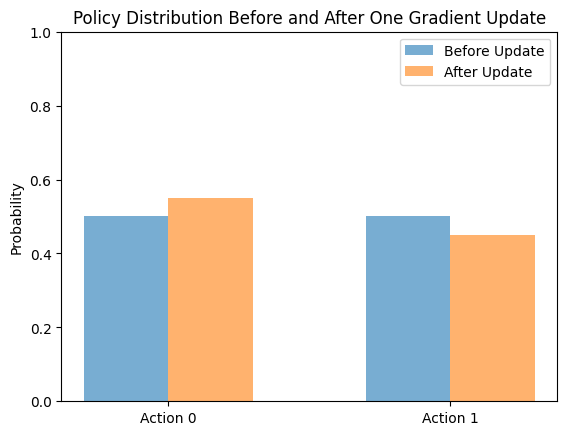

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ---- 1. 初始化策略参数和softmax函数 ----
def softmax(logits):
    e = np.exp(logits)
    return e / np.sum(e)

theta = np.array([0.0, 0.0])     # 两维参数，对应两个动作
lr = 0.1                        # 学习率

def policy(theta):
    """ 返回动作0和动作1的概率 """
    return softmax(theta)

# 计算初始动作概率
p_init = policy(theta)
print("初始概率:", p_init)

# ---- 2. 假设采样到了动作 a=0，并且已知 Advantage(0) > 0，Advantage(1) < 0 ----
A = np.array([+1.0, -1.0])   # 这里仅做演示，表示动作0好过基准，动作1差过基准

# ---- 3. 简单地构造梯度并进行一次更新 ----
# 一个常见做法：对每个选过的动作，用 A * ∇log(pi(动作)) 更新；对于未选动作这里简化处理。
# 为了演示，我们做一个“全量”版本的近似：Δtheta = A * ∂log pi/∂theta

def grad_log_pi(theta):
    """
    返回梯度向量 [grad w.r.t theta[0], grad w.r.t theta[1]] 
    这里我们“批量”地返回对动作0和1分别的 log pi 的梯度近似：
      ∂/∂θ_j (log pi(a|θ)) = 1_{a=j} - pi(a|θ)
    但为了演示把它们放到一起考虑
    """
    p = softmax(theta)
    # grad(a=0) = [1 - p(0), 0 - p(1)]
    grad0 = np.array([1 - p[0],      - p[1]])
    # grad(a=1) = np.array([ -p[0], 1 - p[1] ])
    grad1 = np.array([   -p[0], 1 - p[1] ])
    return np.vstack((grad0, grad1))  # shape (2,2)

g = grad_log_pi(theta)
# 对应到每个动作各自的 advantage，我这里只做一个简单合并，用 A[i]*g[i] 的方式“累加”
grad = A[0] * g[0] + A[1] * g[1]

theta_new = theta + lr * grad

print("更新前theta:", theta)
print("更新后theta:", theta_new)

p_new = policy(theta_new)
print("更新后概率:", p_new)

# ---- 4. 对比更新前后的概率分布 ----
fig, ax = plt.subplots()
bar_width = 0.3

ax.bar([0,1], p_init, width=bar_width, label='Before Update', alpha=0.6)
ax.bar([0+bar_width,1+bar_width], p_new, width=bar_width, label='After Update', alpha=0.6)
ax.set_xticks([0+bar_width/2,1+bar_width/2])
ax.set_xticklabels(['Action 0','Action 1'])
ax.set_ylim(0,1.0)
ax.set_ylabel('Probability')
ax.set_title('Policy Distribution Before and After One Gradient Update')
ax.legend()

### $\log\pi_\theta(A_t|S_t)$ 与 $\nabla_\theta\log\pi_\theta(A_t|S_t)$

- 对数概率，为了简化计算；
    - $\nabla_\theta\pi=\pi\nabla_\theta\log\pi$
- 对数概率的梯度，称为 score function；

### sampling & evaluating

In [7]:
import torch, numpy as np

probs = torch.tensor([0.1, 0.9])
dist = torch.distributions.Categorical(probs)
action = dist.sample()  # => 1
action

tensor(1)

In [8]:
dist.log_prob(action)

tensor(-0.1054)

In [9]:
np.log(0.9)

-0.10536051565782628

### advantage

- $A=(r-b)$
    - b: state, value function
    - r: state & action